# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [7]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from skimage.morphology import watershed

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
OUT_DIR = os.path.abspath("/Users/patrickaleo/Desktop/Illinois/Mask_R-CNN/deblend_maskrcnn/phosim_release/output/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [8]:
class SourcesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "sources"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + star and galaxy

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = SourcesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [9]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [19]:
## DATASET

class PhoSimDataset(utils.Dataset):

    def load_sources(self, max_num=None):
        # load specifications for image Dataset
        # follows load_shapes example
        black = (0,0,0)
        height = 128
        width = 128
        # add DES classes
        self.add_class("des", 1, "star")
        self.add_class("des", 2, "galaxy")

        # find number of sets:
        num_sets = 0
        for setdir in os.listdir(OUT_DIR):
            if 'set_' in setdir:
                num_sets += 1
                if max_num is not None and num_sets > max_num:
                    break

        # add image ids and specs from phosim output directory in order
        for i in range(num_sets):
            for setdir in os.listdir(OUT_DIR):
                search_str = 'set_%d' % i
                if search_str in setdir:
                    # count sources
                    sources = 0
                    for image in os.listdir(os.path.join(OUT_DIR,setdir)):
                        if image.endswith('.fits.gz') and not 'img' in image:
                            sources += 1
                    # add tranining image set
                    self.add_image("des", image_id=i, path=None,
                            width=width, height=height,
                            bg_color=black, sources=sources)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        for setdir in os.listdir(OUT_DIR):
            search_str = 'set_%d' % image_id
            if search_str in setdir:
                # image loop
                for image in os.listdir(os.path.join(OUT_DIR,setdir)):
                    if image.endswith('.fits.gz') and 'img' in image:
                        data = getdata(os.path.join(OUT_DIR,setdir,image))
                        data /= np.max(data)
                        data *= 255
                        break
        # convert format
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image[:,:,0] = data
        image[:,:,1] = data
        image[:,:,2] = data
        image = np.flip(image,0)
        log_img = np.log10(image)
        sim_gal = log_img/np.max(log_img)*255
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "sources":
            return info["sources"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        # load image set via image_id from phosim output directory
        threshold = 0.01 # pixel values above this % of the max value in the
        sources = info['sources'] # number of sources in image
        mask = np.zeros([info['height'], info['width'], sources], dtype=np.uint8)
        markers = np.zeros([info['height'], info['width']], dtype=np.uint8)
        # load image set via image_id from phosim output directory
        # each set directory contains seperate files for images and masks
        class_ids = np.zeros(sources,dtype=np.uint8)
        for setdir in os.listdir(OUT_DIR):
            search_str = 'set_%d' % image_id
            if search_str in setdir:
                # image loop
                i = 0
                for image in os.listdir(os.path.join(OUT_DIR,setdir)):
                    if image.endswith('.fits.gz') and not 'img' in image:
                        data = getdata(os.path.join(OUT_DIR,setdir,image))
                        data /= np.max(data)
                        args = np.argwhere(data > threshold)
                        for arg in args:
                            mask[arg[0],arg[1],i] = 1
                        # Gaussian blur
                        mask[:,:,i] = cv2.GaussianBlur(mask[:,:,i],(25,25),2)
                        # re-apply threshold
                        args = np.argwhere(data > threshold)
                        for arg in args:
                            mask[arg[0],arg[1],i] = 1
                        if 'star' in image:
                            class_ids[i] = 1
                        elif 'gal' in image:
                            class_ids[i] = 2
                            x,y = np.unravel_index(np.argmax(data),data.shape)
                            markers[x,y] = 1
                        i += 1
        # galaxy-galaxy occlusions
        #for j in range(sources):
        #    if class_ids[j] == 1: continue
        #    image = self.load_image(image_id)[:,:,0]
        #    label = watershed(-image, markers, mask=np.sum(mask,2))
        #    if not j % 2 == 0:
        #        mask[:,:,j] = label
        mask = np.flip(mask,0)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [20]:
# Training dataset
dataset_train = PhoSimDataset()
dataset_train.load_sources(10)
dataset_train.prepare()

# Validation dataset
dataset_val = PhoSimDataset()
dataset_val.load_sources(3)
dataset_val.prepare()

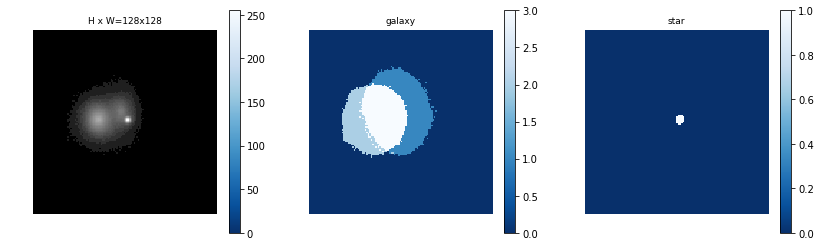

In [28]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(np.log10(image)/np.max(np.log10(image))*255, mask, class_ids, dataset_train.class_names)

## Create Model

In [29]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [30]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [31]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /Users/patrickaleo/Desktop/Illinois/Mask_R-CNN/deblend_maskrcnn/Mask_RCNN/logs/sources20190514T2313/mask_rcnn_sources_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistribute

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


Process ForkPoolWorker-208:
Process ForkPoolWorker-209:
Process ForkPoolWorker-206:
Process ForkPoolWorker-211:
Process ForkPoolWorker-210:
Process ForkPoolWorker-207:
Process ForkPoolWorker-205:
Process ForkPoolWorker-204:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/mult

KeyboardInterrupt: 

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /Users/patrickaleo/Desktop/Illinois/Mask_R-CNN/deblend_maskrcnn/Mask_RCNN/logs/shapes20190513T2109/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 3838s 38s/step - loss: 0.8840 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.3486 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.3097 - val_loss: 1.0078 - val_rpn_class_loss: 0.0177 - val_rpn_bbox_loss: 0.5333 - val_mrcnn_class_loss: 0.0807 - val_mrcnn_bbox_loss: 0.1166 - val_mrcnn_mask_loss: 0.2595


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/patrickaleo/Desktop/Illinois/Mask_R-CNN/deblend_maskrcnn/Mask_RCNN/logs/shapes20190513T2109/mask_rcnn_shapes_0002.h5
Re-starting from epoch 2


original_image           shape: (128, 128, 3)         min:    0.00000  max:  229.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    7.00000  max:  125.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


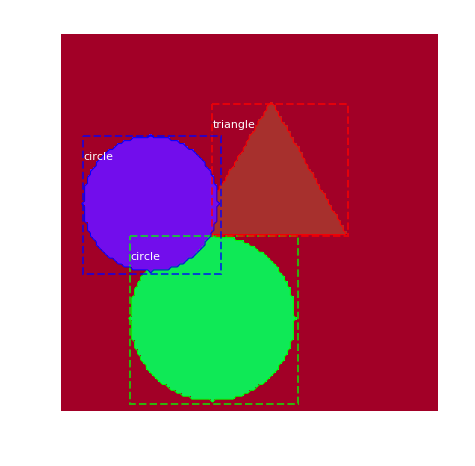

In [19]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  229.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -116.80000  max:  113.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


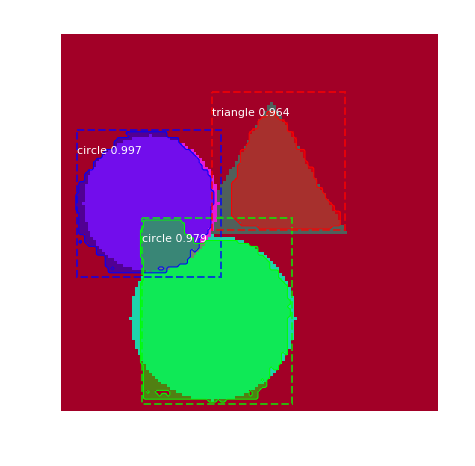

In [20]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
